# On the $\gamma$ of Focal Loss (Extreme Unbalance)


## 1. Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision
import random

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from collections import defaultdict

### 1.1 Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

## confusion matrix
confusion_ce = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_l1 = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_focal2 = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_focal05 = np.zeros((NUM_CLASS, NUM_CLASS))

### 1.2 Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### 1.3 Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)


test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### 1.4 Creating an Unbalanced Training Set

In [5]:

samples_per_class = {
    0: 4000,
    1: 10,
    2: 10,
    3: 10,
    4: 10,
    5: 100,
    6: 10,
    7: 10,
    8: 10,
    9: 10
}



samples_grouped_by_class = defaultdict(list)
for sample in train_set:
    label = sample[1]
    samples_grouped_by_class[label].append(sample)


selected_samples = []
for label, count in samples_per_class.items():
    selected_samples.extend(random.sample(samples_grouped_by_class[label], count))

train_set = selected_samples

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## 2. Model

## 2.1 Define the Neural Network

In [6]:
## define a model which has a softmax layer as the last layer, which is significant when considering L1 Loss and Focal Loss

class ConvNet_DIY(nn.Module):
    def __init__(self):
        super(ConvNet_DIY, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second block
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 
        x = nn.Softmax(dim=1)(x) 
        return x


### 2.2 Define the Loss Functions and train_batch, testing_batch

In [7]:
# Define Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        
        eps = 1e-6
        probs = inputs.clamp(eps, 1. - eps)
        
        # calculate the loss of each class
        class_loss = -targets * torch.log(probs) * self.alpha * (1 - probs)**self.gamma
        
        # sum up
        loss = class_loss.sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [8]:
##################### Define the 4 required Loss Functions##################
FocalLoss_05 = FocalLoss(gamma=0.5)
FocalLoss_1 = FocalLoss(gamma=1)
FocalLoss_2 = FocalLoss(gamma=2)
FocalLoss_3 = FocalLoss(gamma=3)
FocalLoss_4 = FocalLoss(gamma=4)
FocalLoss_5 = FocalLoss(gamma=5)
###############################################################

In [9]:
def train_batch(model, image, target, loss_fn):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
        loss_fn (torch.nn.Module, optional): Loss function to compute the loss.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function.
    """
    
    output = model(image) 
    loss = loss_fn(output, target)

    return output, loss

In [10]:
def test_batch(model, image, target, loss_fn):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image) 
    loss = loss_fn(output, target)
    ###############################################################

    return output, loss

In [11]:
## to adjust "target" to one-hot vector

def to_one_hot(targets, num_classes):
    one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
    one_hot.scatter_(1, targets.unsqueeze(1), 1.)
    return one_hot

## 3 On the choice of $\gamma$

### 3.1 Focal Loss with $\gamma$ = 2

In [12]:
## initial the model for Focal Loss

model = ConvNet_DIY()

model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [13]:
training_loss_Focal2 = []
training_acc_Focal2 = []
testing_loss_Focal2 = []
testing_acc_Focal2 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal2.append(epoch_loss)
    training_acc_Focal2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal2.append(val_loss)
        testing_acc_Focal2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal2 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal2, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0035 Acc: 0.9005
Begin test......
Test Loss: 0.0469 Acc: 0.1000
Epoch: 2/30 Train Loss: 0.0018 Acc: 0.9569
Begin test......
Test Loss: 0.0248 Acc: 0.1000
Epoch: 3/30 Train Loss: 0.0010 Acc: 0.9569
Begin test......
Test Loss: 0.0274 Acc: 0.1000
Epoch: 4/30 Train Loss: 0.0009 Acc: 0.9569
Begin test......
Test Loss: 0.0235 Acc: 0.1000
Epoch: 5/30 Train Loss: 0.0008 Acc: 0.9569
Begin test......
Test Loss: 0.0250 Acc: 0.1051
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.9596
Begin test......
Test Loss: 0.0241 Acc: 0.1009
Epoch: 7/30 Train Loss: 0.0008 Acc: 0.9596
Begin test......
Test Loss: 0.0238 Acc: 0.1024
Epoch: 8/30 Train Loss: 0.0007 Acc: 0.9600
Begin test......
Test Loss: 0.0228 Acc: 0.1122
Epoch: 9/30 Train Loss: 0.0007 Acc: 0.9624
Begin test......
Test Loss: 0.0234 Acc: 0.1079
Epoch: 10/30 Train Loss: 0.0007 Acc: 0.9615
Begin test......
Test Loss: 0.0229 Acc: 0.1101
Epoch: 11/30 Train Loss: 0.0007 Acc: 0.9632
Begin test......
Test Loss: 0.0230 Acc: 0.1120
Epoch: 1

In [14]:
confusion_focal2 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal2, recall_focal2, f1_focal2, _focal2 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal2 = np.mean(precision_focal2)
macro_recall_focal2 = np.mean(recall_focal2)
macro_f1_focal2 = np.mean(f1_focal2)
micro_precision_focal2, micro_recall_focal2, micro_f1_focal2, _focal2 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal2:.4f} Macro Recall: {macro_recall_focal2:.4f} Macro F1: {macro_f1_focal2:.4f}')
print(f'Micro Precision: {micro_precision_focal2:.4f} Micro Recall: {micro_recall_focal2:.4f} Micro F1: {micro_f1_focal2:.4f}')

Macro Precision: 0.8473 Macro Recall: 0.1142 Macro F1: 0.0395
Micro Precision: 0.1142 Micro Recall: 0.1142 Micro F1: 0.1142


### 3.2 Focal Loss with $\gamma = 0.5$

In [15]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [16]:
training_loss_Focal05 = []
training_acc_Focal05 = []
testing_loss_Focal05 = []
testing_acc_Focal05 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_05)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal05.append(epoch_loss)
    training_acc_Focal05.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_05)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal05.append(val_loss)
        testing_acc_Focal05.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal05 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal05, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0034 Acc: 0.9311
Begin test......
Test Loss: 0.0336 Acc: 0.1000
Epoch: 2/30 Train Loss: 0.0014 Acc: 0.9569
Begin test......
Test Loss: 0.0316 Acc: 0.1000
Epoch: 3/30 Train Loss: 0.0013 Acc: 0.9569
Begin test......
Test Loss: 0.0334 Acc: 0.1000
Epoch: 4/30 Train Loss: 0.0012 Acc: 0.9579
Begin test......
Test Loss: 0.0301 Acc: 0.1003
Epoch: 5/30 Train Loss: 0.0011 Acc: 0.9608
Begin test......
Test Loss: 0.0335 Acc: 0.1057
Epoch: 6/30 Train Loss: 0.0011 Acc: 0.9620
Begin test......
Test Loss: 0.0317 Acc: 0.1158
Epoch: 7/30 Train Loss: 0.0010 Acc: 0.9636
Begin test......
Test Loss: 0.0326 Acc: 0.1182
Epoch: 8/30 Train Loss: 0.0010 Acc: 0.9629
Begin test......
Test Loss: 0.0292 Acc: 0.1333
Epoch: 9/30 Train Loss: 0.0010 Acc: 0.9651
Begin test......
Test Loss: 0.0286 Acc: 0.1220
Epoch: 10/30 Train Loss: 0.0009 Acc: 0.9665
Begin test......
Test Loss: 0.0295 Acc: 0.1237
Epoch: 11/30 Train Loss: 0.0009 Acc: 0.9679
Begin test......
Test Loss: 0.0294 Acc: 0.1277
Epoch: 1

In [17]:
confusion_focal05 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal05, recall_focal05, f1_focal05, _focal05 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal05 = np.mean(precision_focal05)
macro_recall_focal05 = np.mean(recall_focal05)
macro_f1_focal05 = np.mean(f1_focal05)
micro_precision_focal05, micro_recall_focal05, micro_f1_focal05, _focal05 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal05:.4f} Macro Recall: {macro_recall_focal05:.4f} Macro F1: {macro_f1_focal05:.4f}')
print(f'Micro Precision: {micro_precision_focal05:.4f} Micro Recall: {micro_recall_focal05:.4f} Micro F1: {micro_f1_focal05:.4f}')

Macro Precision: 0.8426 Macro Recall: 0.1249 Macro F1: 0.0476
Micro Precision: 0.1249 Micro Recall: 0.1249 Micro F1: 0.1249


### 3.3 Focal Loss with $\gamma = 1$

In [18]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [19]:
training_loss_Focal1 = []
training_acc_Focal1 = []
testing_loss_Focal1 = []
testing_acc_Focal1 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_1)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal1.append(epoch_loss)
    training_acc_Focal1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_1)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal1.append(val_loss)
        testing_acc_Focal1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal1 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal1, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0033 Acc: 0.9189
Begin test......
Test Loss: 0.0307 Acc: 0.1000
Epoch: 2/30 Train Loss: 0.0013 Acc: 0.9569
Begin test......
Test Loss: 0.0317 Acc: 0.1000
Epoch: 3/30 Train Loss: 0.0011 Acc: 0.9569
Begin test......
Test Loss: 0.0286 Acc: 0.1000
Epoch: 4/30 Train Loss: 0.0011 Acc: 0.9574
Begin test......
Test Loss: 0.0301 Acc: 0.1007
Epoch: 5/30 Train Loss: 0.0011 Acc: 0.9586
Begin test......
Test Loss: 0.0278 Acc: 0.1044
Epoch: 6/30 Train Loss: 0.0010 Acc: 0.9596
Begin test......
Test Loss: 0.0281 Acc: 0.1054
Epoch: 7/30 Train Loss: 0.0010 Acc: 0.9605
Begin test......
Test Loss: 0.0273 Acc: 0.1067
Epoch: 8/30 Train Loss: 0.0009 Acc: 0.9605
Begin test......
Test Loss: 0.0263 Acc: 0.1120
Epoch: 9/30 Train Loss: 0.0009 Acc: 0.9605
Begin test......
Test Loss: 0.0303 Acc: 0.1022
Epoch: 10/30 Train Loss: 0.0009 Acc: 0.9615
Begin test......
Test Loss: 0.0255 Acc: 0.1158
Epoch: 11/30 Train Loss: 0.0008 Acc: 0.9624
Begin test......
Test Loss: 0.0264 Acc: 0.1157
Epoch: 1

In [20]:
confusion_focal1 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal1, recall_focal1, f1_focal1, _focal1 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal1 = np.mean(precision_focal1)
macro_recall_focal1 = np.mean(recall_focal1)
macro_f1_focal1 = np.mean(f1_focal1)
micro_precision_focal1, micro_recall_focal1, micro_f1_focal1, _focal1 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal1:.4f} Macro Recall: {macro_recall_focal1:.4f} Macro F1: {macro_f1_focal1:.4f}')
print(f'Micro Precision: {micro_precision_focal1:.4f} Micro Recall: {micro_recall_focal1:.4f} Micro F1: {micro_f1_focal1:.4f}')

Macro Precision: 0.8500 Macro Recall: 0.1147 Macro F1: 0.0405
Micro Precision: 0.1147 Micro Recall: 0.1147 Micro F1: 0.1147


### 3.4 Focal Loss with $\gamma = 3$

In [21]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [22]:
training_loss_Focal3 = []
training_acc_Focal3 = []
testing_loss_Focal3 = []
testing_acc_Focal3 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_3)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal3.append(epoch_loss)
    training_acc_Focal3.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_3)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal3.append(val_loss)
        testing_acc_Focal3.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal3 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal3, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0026 Acc: 0.9005
Begin test......
Test Loss: 0.0232 Acc: 0.1000
Epoch: 2/30 Train Loss: 0.0012 Acc: 0.9569
Begin test......
Test Loss: 0.0209 Acc: 0.1000
Epoch: 3/30 Train Loss: 0.0008 Acc: 0.9572
Begin test......
Test Loss: 0.0223 Acc: 0.1000
Epoch: 4/30 Train Loss: 0.0007 Acc: 0.9574
Begin test......
Test Loss: 0.0224 Acc: 0.1004
Epoch: 5/30 Train Loss: 0.0007 Acc: 0.9581
Begin test......
Test Loss: 0.0215 Acc: 0.1013
Epoch: 6/30 Train Loss: 0.0006 Acc: 0.9581
Begin test......
Test Loss: 0.0202 Acc: 0.1052
Epoch: 7/30 Train Loss: 0.0006 Acc: 0.9596
Begin test......
Test Loss: 0.0206 Acc: 0.1082
Epoch: 8/30 Train Loss: 0.0006 Acc: 0.9617
Begin test......
Test Loss: 0.0194 Acc: 0.1146
Epoch: 9/30 Train Loss: 0.0006 Acc: 0.9622
Begin test......
Test Loss: 0.0195 Acc: 0.1117
Epoch: 10/30 Train Loss: 0.0006 Acc: 0.9617
Begin test......
Test Loss: 0.0197 Acc: 0.1135
Epoch: 11/30 Train Loss: 0.0005 Acc: 0.9636
Begin test......
Test Loss: 0.0202 Acc: 0.1121
Epoch: 1

In [23]:
confusion_focal3 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal3, recall_focal3, f1_focal3, _focal3 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal3 = np.mean(precision_focal3)
macro_recall_focal3 = np.mean(recall_focal3)
macro_f1_focal3 = np.mean(f1_focal3)
micro_precision_focal3, micro_recall_focal3, micro_f1_focal3, _focal3 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal3:.4f} Macro Recall: {macro_recall_focal3:.4f} Macro F1: {macro_f1_focal3:.4f}')
print(f'Micro Precision: {micro_precision_focal3:.4f} Micro Recall: {micro_recall_focal3:.4f} Micro F1: {micro_f1_focal3:.4f}')

Macro Precision: 0.8490 Macro Recall: 0.1145 Macro F1: 0.0399
Micro Precision: 0.1145 Micro Recall: 0.1145 Micro F1: 0.1145


### 3.5 Focal Loss with $\gamma = 4$

In [24]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [25]:
training_loss_Focal4 = []
training_acc_Focal4 = []
testing_loss_Focal4 = []
testing_acc_Focal4 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_4)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal4.append(epoch_loss)
    training_acc_Focal4.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_4)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal4.append(val_loss)
        testing_acc_Focal4.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal4 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal4, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0040 Acc: 0.8978
Begin test......
Test Loss: 0.0764 Acc: 0.1000
Epoch: 2/30 Train Loss: 0.0028 Acc: 0.9569
Begin test......
Test Loss: 0.0200 Acc: 0.1000
Epoch: 3/30 Train Loss: 0.0009 Acc: 0.9569
Begin test......
Test Loss: 0.0204 Acc: 0.1000
Epoch: 4/30 Train Loss: 0.0006 Acc: 0.9569
Begin test......
Test Loss: 0.0200 Acc: 0.1000
Epoch: 5/30 Train Loss: 0.0006 Acc: 0.9572
Begin test......
Test Loss: 0.0204 Acc: 0.1000
Epoch: 6/30 Train Loss: 0.0006 Acc: 0.9574
Begin test......
Test Loss: 0.0198 Acc: 0.1033
Epoch: 7/30 Train Loss: 0.0006 Acc: 0.9591
Begin test......
Test Loss: 0.0194 Acc: 0.1079
Epoch: 8/30 Train Loss: 0.0005 Acc: 0.9593
Begin test......
Test Loss: 0.0193 Acc: 0.1082
Epoch: 9/30 Train Loss: 0.0005 Acc: 0.9612
Begin test......
Test Loss: 0.0190 Acc: 0.1051
Epoch: 10/30 Train Loss: 0.0005 Acc: 0.9598
Begin test......
Test Loss: 0.0192 Acc: 0.1068
Epoch: 11/30 Train Loss: 0.0005 Acc: 0.9620
Begin test......
Test Loss: 0.0185 Acc: 0.1141
Epoch: 1

In [26]:
confusion_focal4 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal4, recall_focal4, f1_focal4, _focal4 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal4 = np.mean(precision_focal4)
macro_recall_focal4 = np.mean(recall_focal4)
macro_f1_focal4 = np.mean(f1_focal4)
micro_precision_focal4, micro_recall_focal4, micro_f1_focal4, _focal4 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal4:.4f} Macro Recall: {macro_recall_focal4:.4f} Macro F1: {macro_f1_focal4:.4f}')
print(f'Micro Precision: {micro_precision_focal4:.4f} Micro Recall: {micro_recall_focal4:.4f} Micro F1: {micro_f1_focal4:.4f}')

Macro Precision: 0.8540 Macro Recall: 0.1120 Macro F1: 0.0375
Micro Precision: 0.1120 Micro Recall: 0.1120 Micro F1: 0.1120


### 3.6 Focal Loss with $\gamma = 5$

In [27]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [28]:
training_loss_Focal5 = []
training_acc_Focal5 = []
testing_loss_Focal5 = []
testing_acc_Focal5 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_5)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal5.append(epoch_loss)
    training_acc_Focal5.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_5)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal5.append(val_loss)
        testing_acc_Focal5.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal5 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal5, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0018 Acc: 0.8801
Begin test......
Test Loss: 0.0149 Acc: 0.1000
Epoch: 2/30 Train Loss: 0.0006 Acc: 0.9569
Begin test......
Test Loss: 0.0159 Acc: 0.1000
Epoch: 3/30 Train Loss: 0.0005 Acc: 0.9569
Begin test......
Test Loss: 0.0173 Acc: 0.1000
Epoch: 4/30 Train Loss: 0.0005 Acc: 0.9572
Begin test......
Test Loss: 0.0190 Acc: 0.1000
Epoch: 5/30 Train Loss: 0.0005 Acc: 0.9586
Begin test......
Test Loss: 0.0165 Acc: 0.1052
Epoch: 6/30 Train Loss: 0.0004 Acc: 0.9593
Begin test......
Test Loss: 0.0155 Acc: 0.1038
Epoch: 7/30 Train Loss: 0.0004 Acc: 0.9598
Begin test......
Test Loss: 0.0157 Acc: 0.1037
Epoch: 8/30 Train Loss: 0.0004 Acc: 0.9589
Begin test......
Test Loss: 0.0162 Acc: 0.1031
Epoch: 9/30 Train Loss: 0.0004 Acc: 0.9596
Begin test......
Test Loss: 0.0162 Acc: 0.1050
Epoch: 10/30 Train Loss: 0.0004 Acc: 0.9603
Begin test......
Test Loss: 0.0154 Acc: 0.1057
Epoch: 11/30 Train Loss: 0.0004 Acc: 0.9598
Begin test......
Test Loss: 0.0157 Acc: 0.1083
Epoch: 1

In [29]:
confusion_focal5 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal5, recall_focal5, f1_focal5, _focal5 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal5 = np.mean(precision_focal5)
macro_recall_focal5 = np.mean(recall_focal5)
macro_f1_focal5 = np.mean(f1_focal5)
micro_precision_focal5, micro_recall_focal5, micro_f1_focal5, _focal5 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal5:.4f} Macro Recall: {macro_recall_focal5:.4f} Macro F1: {macro_f1_focal5:.4f}')
print(f'Micro Precision: {micro_precision_focal5:.4f} Micro Recall: {micro_recall_focal5:.4f} Micro F1: {micro_f1_focal5:.4f}')

Macro Precision: 0.8504 Macro Recall: 0.1093 Macro F1: 0.0336
Micro Precision: 0.1093 Micro Recall: 0.1093 Micro F1: 0.1093


## 4. Comparision the Performance of Different Loss on Unbalanced Set

In [30]:
labels = ['Focal Loss γ=0.5', 'Focal Loss γ=1', 'Focal Loss γ=2', 'Focal Loss γ=3', 'Focal Loss γ=4', 'Focal Loss γ=5']

macro_precisions = [macro_precision_focal05, macro_precision_focal1, macro_precision_focal2, macro_precision_focal3, macro_precision_focal4, macro_precision_focal5]
macro_recalls = [macro_recall_focal05, macro_recall_focal1, macro_recall_focal2, macro_recall_focal3, macro_recall_focal4, macro_recall_focal5]
macro_f1s = [macro_f1_focal05, macro_f1_focal1, macro_f1_focal2, macro_f1_focal3, macro_f1_focal4, macro_f1_focal5]

micro_precisions = [micro_precision_focal05, micro_precision_focal1, micro_precision_focal2, micro_precision_focal3, micro_precision_focal4, micro_precision_focal5]
micro_recalls = [micro_recall_focal05, micro_recall_focal1, micro_recall_focal2, micro_recall_focal3, micro_recall_focal4, micro_recall_focal5]
micro_f1s = [micro_f1_focal05,micro_f1_focal1, micro_f1_focal2, micro_f1_focal3, micro_f1_focal4, micro_f1_focal5]

df = pd.DataFrame({
    'Loss Function': labels,
    'Macro Precision': macro_precisions,
    'Macro Recall': macro_recalls,
    'Macro F1': macro_f1s,
    'Micro Precision': micro_precisions,
    'Micro Recall': micro_recalls,
    'Micro F1': micro_f1s
})

# 显示表格
print(df)

      Loss Function  Macro Precision  Macro Recall  Macro F1  Micro Precision  \
0  Focal Loss γ=0.5         0.842579      0.124927  0.047607         0.124927   
1    Focal Loss γ=1         0.850025      0.114740  0.040495         0.114740   
2    Focal Loss γ=2         0.847279      0.114190  0.039502         0.114190   
3    Focal Loss γ=3         0.849047      0.114487  0.039945         0.114487   
4    Focal Loss γ=4         0.854008      0.111953  0.037467         0.111953   
5    Focal Loss γ=5         0.850421      0.109270  0.033640         0.109270   

   Micro Recall  Micro F1  
0      0.124927  0.124927  
1      0.114740  0.114740  
2      0.114190  0.114190  
3      0.114487  0.114487  
4      0.111953  0.111953  
5      0.109270  0.109270  


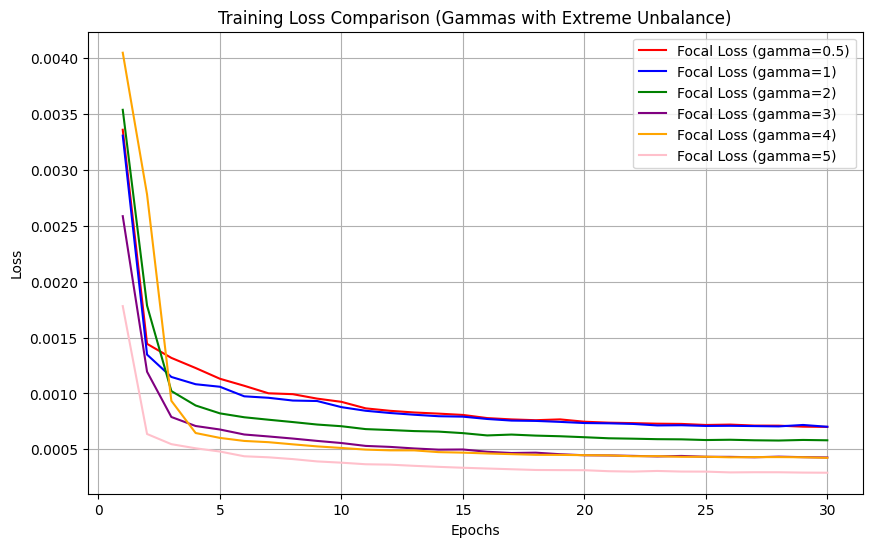

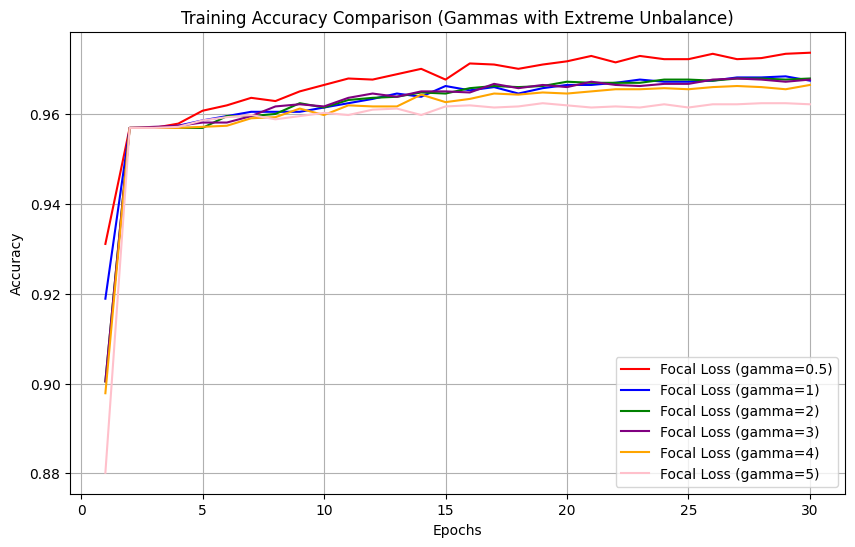

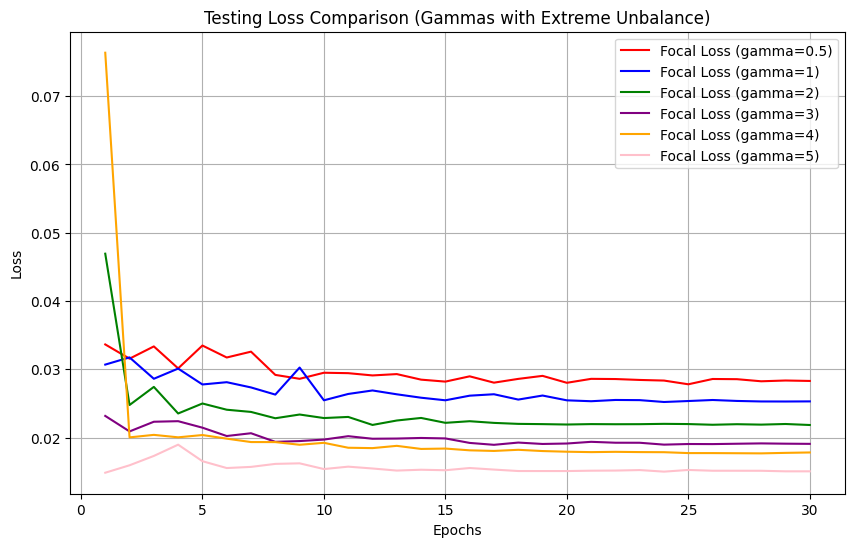

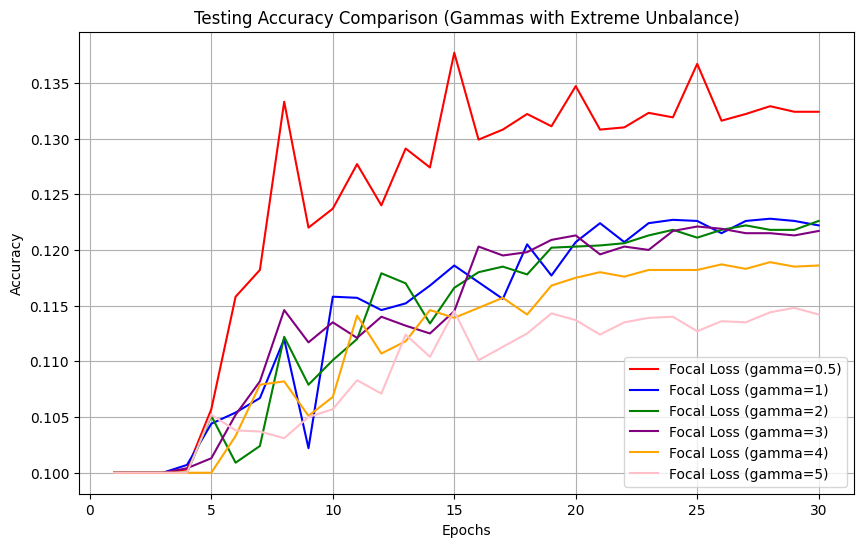

In [32]:
epochs = range(1, len(training_loss_Focal05) + 1)

# 训练损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_Focal05, label='Focal Loss (gamma=0.5)', color='red')
plt.plot(epochs, training_loss_Focal1, label='Focal Loss (gamma=1)', color='blue')
plt.plot(epochs, training_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_loss_Focal3, label='Focal Loss (gamma=3)', color='purple')
plt.plot(epochs, training_loss_Focal4, label='Focal Loss (gamma=4)', color='orange')
plt.plot(epochs, training_loss_Focal5, label='Focal Loss (gamma=5)', color='pink')
plt.title('Training Loss Comparison (Gammas with Extreme Unbalance)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_loss_comparison_gamma_extreme.png')
plt.show()

# 训练准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_Focal05, label='Focal Loss (gamma=0.5)', color='red')
plt.plot(epochs, training_acc_Focal1, label='Focal Loss (gamma=1)', color='blue')
plt.plot(epochs, training_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_acc_Focal3, label='Focal Loss (gamma=3)', color='purple')
plt.plot(epochs, training_acc_Focal4, label='Focal Loss (gamma=4)', color='orange')
plt.plot(epochs, training_acc_Focal5, label='Focal Loss (gamma=5)', color='pink')
plt.title('Training Accuracy Comparison (Gammas with Extreme Unbalance)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_accuracy_comparison_gamma_extreme.png')
plt.show()

# 测试损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_loss_Focal05, label='Focal Loss (gamma=0.5)', color='red')
plt.plot(epochs, testing_loss_Focal1, label='Focal Loss (gamma=1)', color='blue')
plt.plot(epochs, testing_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_loss_Focal3, label='Focal Loss (gamma=3)', color='purple')
plt.plot(epochs, testing_loss_Focal4, label='Focal Loss (gamma=4)', color='orange')
plt.plot(epochs, testing_loss_Focal5, label='Focal Loss (gamma=5)', color='pink')
plt.title('Testing Loss Comparison (Gammas with Extreme Unbalance)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_loss_comparison_gamma_extreme.png')
plt.show()

# 测试准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_acc_Focal05, label='Focal Loss (gamma=0.5)', color='red')
plt.plot(epochs, testing_acc_Focal1, label='Focal Loss (gamma=1)', color='blue')
plt.plot(epochs, testing_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_acc_Focal3, label='Focal Loss (gamma=3)', color='purple')
plt.plot(epochs, testing_acc_Focal4, label='Focal Loss (gamma=4)', color='orange')
plt.plot(epochs, testing_acc_Focal5, label='Focal Loss (gamma=5)', color='pink')
plt.title('Testing Accuracy Comparison (Gammas with Extreme Unbalance)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_accuracy_comparison_gamma_extreme.png')
plt.show()

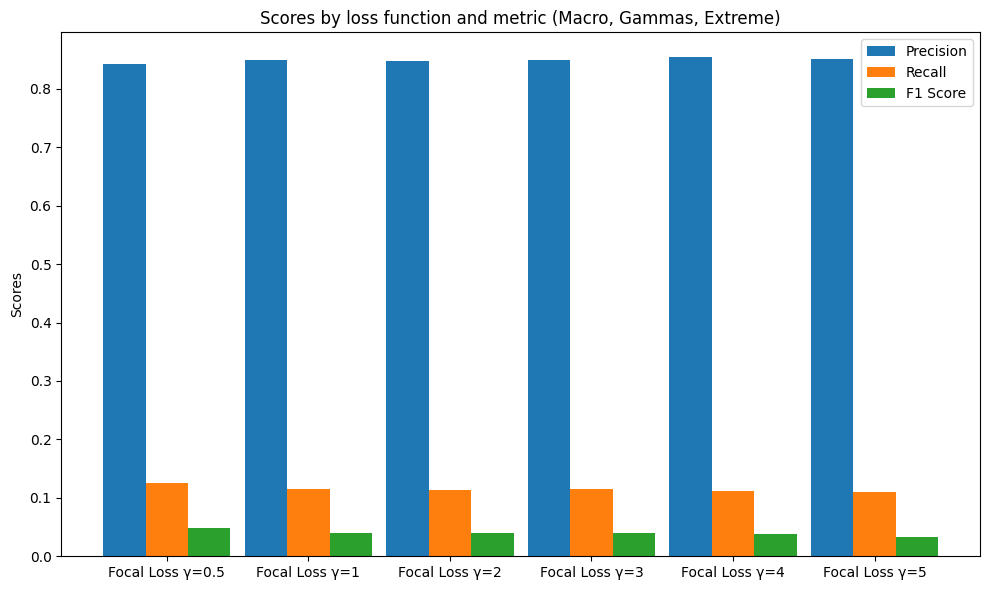

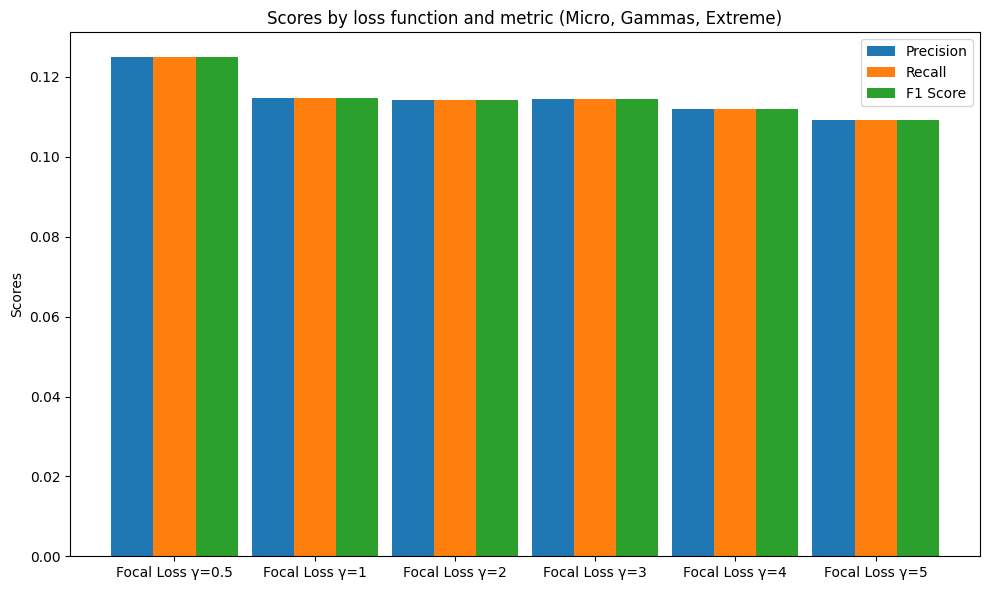

In [33]:
# Marco
x = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, macro_precisions, width, label='Precision')
rects2 = ax.bar(x, macro_recalls, width, label='Recall')
rects3 = ax.bar(x + width, macro_f1s, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by loss function and metric (Macro, Gammas, Extreme)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('pic/macro_scores_gamma_extreme.png')
plt.show()

# Micro
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, micro_precisions, width, label='Precision')
rects2 = ax.bar(x, micro_recalls, width, label='Recall')
rects3 = ax.bar(x + width, micro_f1s, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by loss function and metric (Micro, Gammas, Extreme)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('pic/micro_scores_gamma_extreme.png')
plt.show()

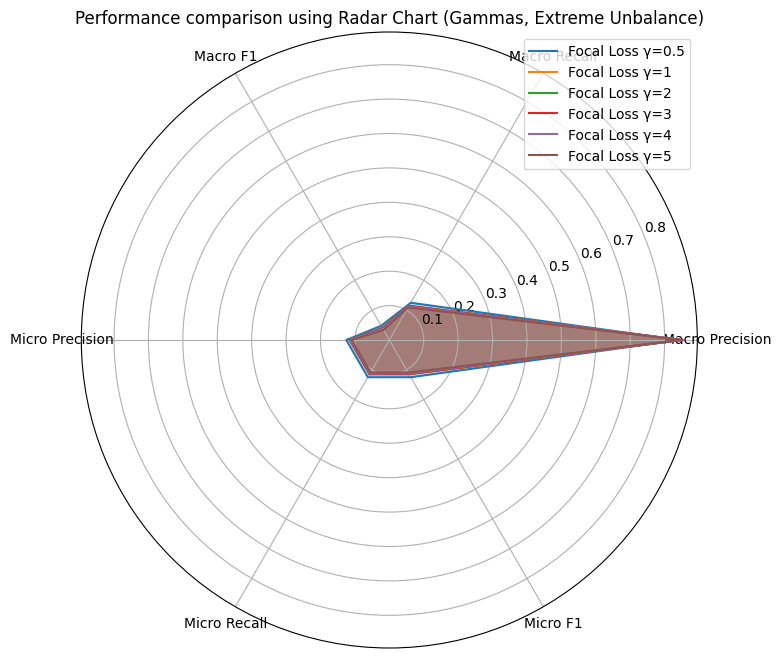

In [34]:
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1', 'Micro Precision', 'Micro Recall', 'Micro F1']
values_list = [
    [macro_precision_focal05, macro_recall_focal05, macro_f1_focal05, micro_precision_focal05, micro_recall_focal05, micro_f1_focal05],
    [macro_precision_focal1, macro_recall_focal1, macro_f1_focal1, micro_precision_focal1, micro_recall_focal1, micro_f1_focal1],
    [macro_precision_focal2, macro_recall_focal2, macro_f1_focal2, micro_precision_focal2, micro_recall_focal2, micro_f1_focal2],
    [macro_precision_focal3, macro_recall_focal3, macro_f1_focal3, micro_precision_focal3, micro_recall_focal3, micro_f1_focal3],
    [macro_precision_focal4, macro_recall_focal4, macro_f1_focal4, micro_precision_focal4, micro_recall_focal4, micro_f1_focal4],
    [macro_precision_focal5, macro_recall_focal5, macro_f1_focal5, micro_precision_focal5, micro_recall_focal5, micro_f1_focal5],
]

# draw the Radar Chart
N = len(metrics)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
theta = np.concatenate((theta, [theta[0]]))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

for values, label in zip(values_list, labels):
    values = np.concatenate((values, [values[0]]))  # Close the loop
    ax.plot(theta, values, label=label)
    ax.fill(theta, values, alpha=0.25)

ax.set_xticks(theta[:-1])
ax.set_xticklabels(metrics)
ax.set_title("Performance comparison using Radar Chart (Gammas, Extreme Unbalance)")
ax.legend(loc='upper right')
plt.savefig('pic/radar_gamma_extreme.png')
plt.show()